# 06 - Hyperparameter Tuning
This notebook uses GridSearchCV and RandomizedSearchCV to optimize model hyperparameters for the best performing models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load raw dataset; derive target. Preprocessing happens inside pipelines
DATA_PATH = '../data/processed.cleveland.data'
COLUMNS = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]
df = pd.read_csv(DATA_PATH, header=None, names=COLUMNS, na_values=['?'])
df['target'] = (df['num'] > 0).astype(int)
df = df.drop('num', axis=1)

# Define preprocessing (fit within CV/pipeline)
NUMERIC_FEATURES = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_FEATURES = ['cp', 'restecg', 'slope', 'ca', 'thal']
BINARY_FEATURES = ['sex', 'fbs', 'exang']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, NUMERIC_FEATURES + BINARY_FEATURES),
    ('cat', categorical_transformer, CATEGORICAL_FEATURES)
])

# Target variable is already present as 'target' in the cleaned dataset

print('Dataset shape:', df.shape)
df.head()

Dataset shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [2]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)

Training set size: (242, 13)
Test set size: (61, 13)


In [3]:
# 1. Random Forest Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42)

# Parameter grid
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=rf_param_grid, 
    n_iter=50, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=42
)

print('Performing Random Forest Randomized Search...')
rf_random_search.fit(X_train, y_train)

print('Best parameters (Randomized Search):', rf_random_search.best_params_)
print('Best ROC AUC (Randomized Search):', rf_random_search.best_score_)

# GridSearchCV for comparison
rf_grid_search = GridSearchCV(
    rf_pipeline, rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

print('\nPerforming Random Forest Grid Search...')
rf_grid_search.fit(X_train, y_train)

print('Best parameters (Grid Search):', rf_grid_search.best_params_)
print('Best ROC AUC (Grid Search):', rf_grid_search.best_score_)

Performing Random Forest Randomized Search...
Best parameters (Randomized Search): {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 5}
Best ROC AUC (Randomized Search): 0.8995664560881952

Performing Random Forest Grid Search...
Best parameters (Grid Search): {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best ROC AUC (Grid Search): 0.8999054086010607


In [4]:
# 2. SVM Hyperparameter Tuning
svm_model = SVC(probability=True, random_state=42)

# Parameter grid
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01]
}

# RandomizedSearchCV for broader exploration
svm_param_distributions = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__kernel': ['rbf', 'linear'],
    'classifier__gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
}

svm_random_search = RandomizedSearchCV(
    svm_pipeline, svm_param_distributions, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42
)

# GridSearchCV
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

print('Performing SVM Randomized Search...')
svm_random_search.fit(X_train, y_train)
print('Best parameters (Randomized):', svm_random_search.best_params_)
print('Best ROC AUC (Randomized):', svm_random_search.best_score_)

print('Performing SVM Grid Search...')
svm_grid_search.fit(X_train, y_train)

print('Best parameters:', svm_grid_search.best_params_)
print('Best ROC AUC:', svm_grid_search.best_score_)

Performing SVM Randomized Search...
Best parameters (Randomized): {'classifier__kernel': 'linear', 'classifier__gamma': 0.001, 'classifier__C': 0.1}
Best ROC AUC (Randomized): 0.8921038703647399
Performing SVM Grid Search...
Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
Best ROC AUC: 0.895113903809556


In [5]:
# 3. Logistic Regression Hyperparameter Tuning
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Parameter grid
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

lr_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# RandomizedSearchCV for LR
lr_param_distributions = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

lr_random_search = RandomizedSearchCV(
    lr_pipeline, lr_param_distributions, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1, random_state=42
)

# GridSearchCV
lr_grid_search = GridSearchCV(
    lr_pipeline, lr_param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

print('Performing Logistic Regression Randomized Search...')
lr_random_search.fit(X_train, y_train)
print('Best parameters (Randomized):', lr_random_search.best_params_)
print('Best ROC AUC (Randomized):', lr_random_search.best_score_)

print('Performing Logistic Regression Grid Search...')
lr_grid_search.fit(X_train, y_train)

print('Best parameters:', lr_grid_search.best_params_)
print('Best ROC AUC:', lr_grid_search.best_score_)

Performing Logistic Regression Randomized Search...


c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=30. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters (Randomized): {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 1}
Best ROC AUC (Randomized): 0.8968689120863035
Performing Logistic Regression Grid Search...
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best ROC AUC: 0.8968689120863035


In [6]:
# 4. Decision Tree Hyperparameter Tuning
dt_model = DecisionTreeClassifier(random_state=42)

# Parameter grid
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt_model)
])

dt_param_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [None, 3, 5, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 8],
    'classifier__class_weight': [None, 'balanced']
}

# RandomizedSearchCV
dt_random_search = RandomizedSearchCV(
    dt_pipeline,
    param_distributions=dt_param_grid,
    n_iter=50,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

print('Performing Decision Tree Randomized Search...')
dt_random_search.fit(X_train, y_train)
print('Best parameters (Randomized):', dt_random_search.best_params_)
print('Best ROC AUC (Randomized):', dt_random_search.best_score_)

# GridSearchCV
dt_grid_search = GridSearchCV(
    dt_pipeline, dt_param_grid, cv=5, scoring='roc_auc', n_jobs=-1
)

print('Performing Decision Tree Grid Search...')
dt_grid_search.fit(X_train, y_train)
print('Best parameters:', dt_grid_search.best_params_)
print('Best ROC AUC:', dt_grid_search.best_score_)

Performing Decision Tree Randomized Search...
Best parameters (Randomized): {'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 8, 'classifier__max_depth': 20, 'classifier__criterion': 'gini', 'classifier__class_weight': None}
Best ROC AUC (Randomized): 0.8441285767372724
Performing Decision Tree Grid Search...
Best parameters: {'classifier__class_weight': None, 'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2}
Best ROC AUC: 0.8441285767372724


In [7]:
# Evaluate best models
best_models = {
    'Random Forest (Randomized)': rf_random_search.best_estimator_,
    'Random Forest (Grid)': rf_grid_search.best_estimator_,
    'SVM (Randomized)': svm_random_search.best_estimator_,
    'SVM (Grid)': svm_grid_search.best_estimator_,
    'Logistic Regression (Randomized)': lr_random_search.best_estimator_,
    'Logistic Regression (Grid)': lr_grid_search.best_estimator_,
    'Decision Tree (Randomized)': dt_random_search.best_estimator_,
    'Decision Tree (Grid)': dt_grid_search.best_estimator_
}

tuned_results = []

for name, model in best_models.items():
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    tuned_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    
    print(f'{name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}')

Random Forest (Randomized) - Accuracy: 0.8852, Precision: 0.8387, Recall: 0.9286, F1: 0.8814, ROC AUC: 0.9502
Random Forest (Grid) - Accuracy: 0.9016, Precision: 0.8667, Recall: 0.9286, F1: 0.8966, ROC AUC: 0.9513
SVM (Randomized) - Accuracy: 0.8525, Precision: 0.8065, Recall: 0.8929, F1: 0.8475, ROC AUC: 0.9426
SVM (Grid) - Accuracy: 0.8689, Precision: 0.8333, Recall: 0.8929, F1: 0.8621, ROC AUC: 0.9665
Logistic Regression (Randomized) - Accuracy: 0.8689, Precision: 0.8333, Recall: 0.8929, F1: 0.8621, ROC AUC: 0.9600
Logistic Regression (Grid) - Accuracy: 0.8689, Precision: 0.8333, Recall: 0.8929, F1: 0.8621, ROC AUC: 0.9600
Decision Tree (Randomized) - Accuracy: 0.8197, Precision: 0.7931, Recall: 0.8214, F1: 0.8070, ROC AUC: 0.8923
Decision Tree (Grid) - Accuracy: 0.8197, Precision: 0.7931, Recall: 0.8214, F1: 0.8070, ROC AUC: 0.8923


In [8]:
# Display tuned results
tuned_results_df = pd.DataFrame(tuned_results)
tuned_results_df = tuned_results_df.sort_values('ROC AUC', ascending=False)
print('\nTuned Model Performance Summary:')
print(tuned_results_df)


Tuned Model Performance Summary:
                              Model  Accuracy  Precision    Recall  F1-Score  \
3                        SVM (Grid)  0.868852   0.833333  0.892857  0.862069   
4  Logistic Regression (Randomized)  0.868852   0.833333  0.892857  0.862069   
5        Logistic Regression (Grid)  0.868852   0.833333  0.892857  0.862069   
1              Random Forest (Grid)  0.901639   0.866667  0.928571  0.896552   
0        Random Forest (Randomized)  0.885246   0.838710  0.928571  0.881356   
2                  SVM (Randomized)  0.852459   0.806452  0.892857  0.847458   
6        Decision Tree (Randomized)  0.819672   0.793103  0.821429  0.807018   
7              Decision Tree (Grid)  0.819672   0.793103  0.821429  0.807018   

    ROC AUC  
3  0.966450  
4  0.959957  
5  0.959957  
1  0.951299  
0  0.950216  
2  0.942641  
6  0.892316  
7  0.892316  


In [9]:
# Append tuned results to evaluation_metrics.txt
metrics_path = '../results/evaluation_metrics.txt'
os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
with open(metrics_path, 'a', encoding='utf-8') as f:
    f.write('=== Tuned Model Performance ===\n')
    f.write(tuned_results_df.to_string(index=False))
    f.write('\n\n')
print(f'Tuned results appended to {metrics_path}')

# Save best overall model
best_overall_model = tuned_results_df.iloc[0]['Model']
best_model = best_models[best_overall_model]

models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)
final_model_path = os.path.join(models_dir, 'final_model.pkl')
joblib.dump(best_model, final_model_path)
print(f'Best overall model ({best_overall_model}) saved to {final_model_path}')

Tuned results appended to ../results/evaluation_metrics.txt
Best overall model (SVM (Grid)) saved to ../models\final_model.pkl


<Figure size 1200x600 with 0 Axes>

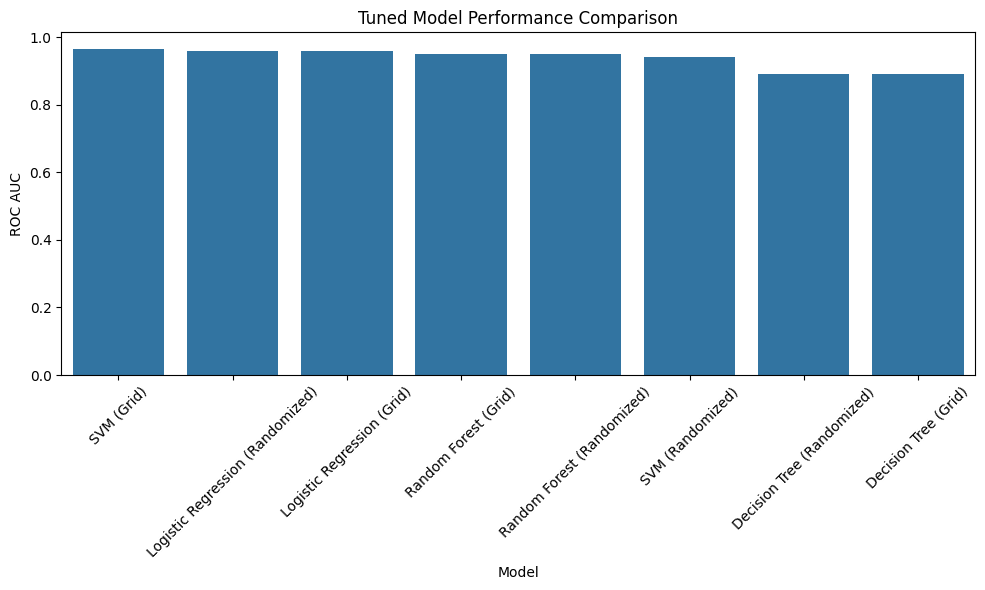

In [10]:
# Visualize improvement
plt.figure(figsize=(12, 6))

# Combine results for comparison
comparison_df = pd.concat([
    pd.DataFrame(tuned_results),
    pd.DataFrame([{'Model': 'Random Forest (Tuned)', 'ROC AUC': rf_grid_search.best_score_}]),
    pd.DataFrame([{'Model': 'SVM (Tuned)', 'ROC AUC': svm_grid_search.best_score_}]),
    pd.DataFrame([{'Model': 'Logistic Regression (Tuned)', 'ROC AUC': lr_grid_search.best_score_}]),
    pd.DataFrame([{'Model': 'Decision Tree (Tuned)', 'ROC AUC': dt_grid_search.best_score_}])
])

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='ROC AUC', data=tuned_results_df)
plt.title('Tuned Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()